In [1]:
from google.colab import drive
drive.mount("/content/drive")

DATA_DIR = "/content/drive/MyDrive/Task_C"



Mounted at /content/drive


In [2]:
import os
os.environ["WANDB_DISABLED"] = "true"
import torch
import numpy as np
import pandas as pd
from datasets import load_dataset, Dataset
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    DataCollatorWithPadding
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import argparse
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path

We suggest using a single class, it will make refinement easier.

In your implementation, feel free to update the training procedure, change model and do whatever feels right

In [ ]:
# =========================
# CodeBERTTrainer (COLAB-STABLE + CACHE TOKENIZATION ONCE)
# =========================

from pathlib import Path
import os
import shutil
import numpy as np
import pandas as pd
import torch

from datasets import Dataset, load_from_disk
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report


class CodeBERTTrainerV2:
    """
    Colab-stable version:
    - Tokenizes ONCE and caches tokenized HF Datasets to disk.
    """

    def __init__(
        self,
        data_dir: str,
        max_length: int = 512,
        model_name: str = "microsoft/codebert-base",
        cache_dir: str | None = None,
        hf_cache_dir: str | None = None,   # optional HF cache
    ):
        self.data_dir = Path(data_dir)
        self.max_length = max_length
        self.model_name = model_name

        self.tokenizer = None
        self.model = None
        self.num_labels = None

        if cache_dir is None:
            cache_dir = str(self.data_dir / "tokenized_cache_local")
        self.tokenized_cache_root = Path(cache_dir)
        self.tokenized_cache_root.mkdir(parents=True, exist_ok=True)

        if hf_cache_dir is not None:
            os.environ["HF_DATASETS_CACHE"] = hf_cache_dir
            os.environ["HF_HOME"] = hf_cache_dir

        # Perf tweaks (safe)
        if torch.cuda.is_available():
            torch.backends.cuda.matmul.allow_tf32 = True
            torch.backends.cudnn.allow_tf32 = True

    # -------------------------
    # Data
    # -------------------------
    def load_and_prepare_data(self):
        train_path = self.data_dir / "train.parquet"
        val_path = self.data_dir / "validation.parquet"

        if not train_path.exists():
            raise FileNotFoundError(f"Missing train file: {train_path}")
        if not val_path.exists():
            raise FileNotFoundError(f"Missing validation file: {val_path}")

        df = pd.read_parquet(train_path)
        val_df = pd.read_parquet(val_path)

        for name, d in [("train", df), ("validation", val_df)]:
            if "code" not in d.columns or "label" not in d.columns:
                raise ValueError(f"{name} parquet must contain 'code' and 'label' columns")

        df = df.dropna(subset=["code", "label"]).copy()
        val_df = val_df.dropna(subset=["code", "label"]).copy()

        df["label"] = df["label"].astype(int)
        val_df["label"] = val_df["label"].astype(int)

        self.num_labels = int(df["label"].nunique())

        print(f"Train samples: {len(df)} | Val samples: {len(val_df)}")
        print(f"Num labels: {self.num_labels}")
        print("Train label distribution:\n", df["label"].value_counts().sort_index())

        return df, val_df

    # -------------------------
    # Model
    # -------------------------
    def initialize_model_and_tokenizer(self):
        print(f"Initializing model/tokenizer: {self.model_name}")

        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name, use_fast=True)
        self.model = AutoModelForSequenceClassification.from_pretrained(
            self.model_name,
            num_labels=self.num_labels,
            problem_type="single_label_classification",
        )

        device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model.to(device)
        print(f"Model on {device} with {self.num_labels} labels")

    # -------------------------
    # Tokenization
    # -------------------------
    def tokenize_function(self, examples):
        return self.tokenizer(
            examples["code"],
            truncation=True,
            max_length=self.max_length,
            padding=False,
        )

    def _cache_paths(self, debug_n=None):
        key = f"{self.model_name.replace('/', '_')}_L{self.max_length}"
        if debug_n is not None:
            key += f"_N{debug_n}"
        train_cache = self.tokenized_cache_root / f"{key}_train"
        val_cache = self.tokenized_cache_root / f"{key}_val"
        return train_cache, val_cache

    def prepare_datasets(
        self,
        train_df,
        val_df,
        debug_n=None,
        force_retokenize=False,
        map_num_proc=1,
        map_batch_size=256,
    ):
        if self.tokenizer is None:
            raise RuntimeError("Tokenizer not initialized. Call initialize_model_and_tokenizer() first.")

        train_cache, val_cache = self._cache_paths(debug_n=debug_n)

        if not force_retokenize and train_cache.exists() and val_cache.exists():
            print(f"Loading tokenized datasets from cache:\n- {train_cache}\n- {val_cache}")
            train_dataset = load_from_disk(str(train_cache))
            val_dataset = load_from_disk(str(val_cache))
            return train_dataset, val_dataset

        print("Tokenizing datasets (first time) and saving cache...")

        train_dataset = Dataset.from_pandas(train_df[["code", "label"]], preserve_index=False)
        val_dataset = Dataset.from_pandas(val_df[["code", "label"]], preserve_index=False)

        if debug_n is not None:
            train_dataset = train_dataset.select(range(min(debug_n, len(train_dataset))))
            val_dataset = val_dataset.select(range(min(debug_n, len(val_dataset))))

        # Colab tip: multiprocessing often hurts stability; keep it 1 unless you KNOW it's safe.
        train_dataset = train_dataset.map(
            self.tokenize_function,
            batched=True,
            batch_size=map_batch_size,
            num_proc=map_num_proc,
            remove_columns=["code"],
            desc="Tokenizing train",
        )
        val_dataset = val_dataset.map(
            self.tokenize_function,
            batched=True,
            batch_size=map_batch_size,
            num_proc=map_num_proc,
            remove_columns=["code"],
            desc="Tokenizing val",
        )

        train_dataset = train_dataset.rename_column("label", "labels")
        val_dataset = val_dataset.rename_column("label", "labels")

        # Save tokenized cache
        train_dataset.save_to_disk(str(train_cache))
        val_dataset.save_to_disk(str(val_cache))
        print(f"Saved tokenized datasets to cache:\n- {train_cache}\n- {val_cache}")

        return train_dataset, val_dataset

    # -------------------------
    # Metrics
    # -------------------------
    def compute_metrics(self, eval_pred):
      logits, labels = eval_pred
      preds = np.argmax(logits, axis=1)

      acc = accuracy_score(labels, preds)

      p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(
          labels, preds, average="macro", zero_division=0
      )
      p_w, r_w, f1_w, _ = precision_recall_fscore_support(
          labels, preds, average="weighted", zero_division=0
      )

      return {
          "accuracy": acc,
          "f1_macro": f1_macro,
          "precision_macro": p_macro,
          "recall_macro": r_macro,
          "f1_weighted": f1_w,
      }

    # -------------------------
    # Train
    # -------------------------
    def train(
        self,
        train_dataset,
        val_dataset,
        output_dir="./results",
        num_epochs=7,
        batch_size=64,
        learning_rate=2e-5,
        grad_accum=4,
        fp16=True,
        eval_steps=3500,
        save_steps=3500,
        logging_steps=200,
        max_steps=-1,
        num_workers=4,
        gradient_checkpointing=False,
        warmup_ratio=0.1,
        weight_decay=0.001,
        early_stop_patience=2,
        use_adamw_fused=True,   # ✅ requested
    ):
        device = "cuda" if torch.cuda.is_available() else "cpu"
        use_fp16 = False
        use_bf16 = (device == "cuda")

        print("Starting training...")
        print("Device:", device)
        print("fp16:", use_fp16)
        print("bf16:", use_bf16)
        print("Model:", self.model_name)
        print("max_length:", self.max_length)
        print("batch_size (per device):", batch_size)
        print("grad_accum:", grad_accum, "=> effective batch:", batch_size * grad_accum)
        print("learning_rate:", learning_rate)
        print("weight_decay:", weight_decay)
        print("warmup_ratio:", warmup_ratio)
        print("eval_steps:", eval_steps, "| save_steps:", save_steps)

        if gradient_checkpointing and hasattr(self.model, "gradient_checkpointing_enable"):
            self.model.gradient_checkpointing_enable()
            print("Enabled gradient checkpointing.")

        optim_choice = "adamw_torch"
        if use_adamw_fused and device == "cuda":
            optim_choice = "adamw_torch_fused"

        training_args = TrainingArguments(
            output_dir=output_dir,
            num_train_epochs=num_epochs,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            gradient_accumulation_steps=grad_accum,

            learning_rate=learning_rate,
            weight_decay=weight_decay,
            warmup_ratio=warmup_ratio,
            lr_scheduler_type="linear",

            logging_dir=os.path.join(output_dir, "logs"),
            logging_strategy="steps",
            logging_steps=logging_steps,

            eval_strategy="steps",
            eval_steps=eval_steps,

            save_strategy="steps",
            save_steps=save_steps,
            save_total_limit=2,

            load_best_model_at_end=True,
            metric_for_best_model="f1_macro",
            greater_is_better=True,

            remove_unused_columns=False,
            report_to=[],

            bf16=use_bf16,
            fp16=False,
            dataloader_num_workers=num_workers,
            dataloader_pin_memory=True,

            max_steps=max_steps,
            optim=optim_choice,
        )

        data_collator = DataCollatorWithPadding(tokenizer=self.tokenizer)

        trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            tokenizer=self.tokenizer,
            data_collator=data_collator,
            compute_metrics=self.compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=early_stop_patience)],
        )

        try:
            trainer.train()
        except Exception as e:
            if "adamw_torch_fused" in str(e) or "optim" in str(e):
                print("⚠️ Fused AdamW not supported in this environment. Falling back to adamw_torch.")
                training_args.optim = "adamw_torch"
                trainer = Trainer(
                    model=self.model,
                    args=training_args,
                    train_dataset=train_dataset,
                    eval_dataset=val_dataset,
                    tokenizer=self.tokenizer,
                    data_collator=data_collator,
                    compute_metrics=self.compute_metrics,
                    callbacks=[EarlyStoppingCallback(early_stopping_patience=early_stop_patience)],
                )
                trainer.train()
            else:
                raise

        trainer.save_model(output_dir)
        self.tokenizer.save_pretrained(output_dir)
        print(f"Training completed. Model saved to {output_dir}")

        return trainer


    # -------------------------
    # Evaluate
    # -------------------------
    def evaluate_model(self, trainer, val_dataset, out_dir="./results"):
      print("Evaluating model...")
      preds = trainer.predict(val_dataset)

      logits = preds.predictions
      y_true = preds.label_ids
      y_pred = np.argmax(logits, axis=1)

      print(classification_report(y_true, y_pred, zero_division=0))

      os.makedirs(out_dir, exist_ok=True)
      np.save(os.path.join(out_dir, "val_logits.npy"), logits)
      np.save(os.path.join(out_dir, "val_labels.npy"), y_true)
      print(f"Saved val logits/labels to: {out_dir}")

      return preds


    # -------------------------
    # Full pipeline
    # -------------------------
    def run_full_pipeline(
        self,
        output_dir="./results",
        num_epochs=7,
        batch_size=64,
        learning_rate=2e-5,
        debug_n=None,
        force_retokenize=False,
        map_num_proc=1,
        map_batch_size=256,
        grad_accum=4,
        fp16=True,
        eval_steps=3500,
        save_steps=3500,
        logging_steps=200,
        max_steps=-1,
        num_workers=4,
        gradient_checkpointing=False,
        warmup_ratio=0.1,
        weight_decay=0.001,
        early_stop_patience=2,
        use_adamw_fused=True,
    ):
        # 1) Load data
        train_df, val_df = self.load_and_prepare_data()

        # 2) Init tokenizer/model
        self.initialize_model_and_tokenizer()

        # 3) Tokenize (cached)
        train_dataset, val_dataset = self.prepare_datasets(
            train_df,
            val_df,
            debug_n=debug_n,
            force_retokenize=force_retokenize,
            map_num_proc=map_num_proc,
            map_batch_size=map_batch_size,
        )

        # 4) Train
        trainer = self.train(
            train_dataset=train_dataset,
            val_dataset=val_dataset,
            output_dir=output_dir,
            num_epochs=num_epochs,
            batch_size=batch_size,
            learning_rate=learning_rate,
            grad_accum=grad_accum,
            fp16=fp16,
            eval_steps=eval_steps,
            save_steps=save_steps,
            logging_steps=logging_steps,
            max_steps=max_steps,
            num_workers=num_workers,
            gradient_checkpointing=gradient_checkpointing,
            warmup_ratio=warmup_ratio,
            weight_decay=weight_decay,
            early_stop_patience=early_stop_patience,
            use_adamw_fused=use_adamw_fused,
        )

        # 5) Final eval
        self.evaluate_model(trainer, val_dataset)
        print("Pipeline completed successfully!")
        return trainer


# -------------------------
# Optional helper: copy cache to Drive after tokenization
# -------------------------
def copy_cache_to_drive(local_cache_dir: str, drive_cache_dir: str):
    local_cache_dir = Path(local_cache_dir)
    drive_cache_dir = Path(drive_cache_dir)
    drive_cache_dir.mkdir(parents=True, exist_ok=True)

    # copytree into drive (can be slow)
    for item in local_cache_dir.iterdir():
        dst = drive_cache_dir / item.name
        if dst.exists():
            shutil.rmtree(dst)
        shutil.copytree(item, dst)
    print(f"Copied cache from {local_cache_dir} to {drive_cache_dir}")


In [ ]:
trainer_obj = CodeBERTTrainerV2(
    data_dir="/content/drive/MyDrive/Task_C",
    max_length=512,
    model_name="microsoft/codebert-base",
    cache_dir="/content/tokenized_cache_local",
)

trainer = trainer_obj.run_full_pipeline(
    output_dir="/content/results_codebert",
    num_epochs=5,
    batch_size=64,
    grad_accum=4,                 # eff batch 256
    learning_rate=2e-5,
    weight_decay=0.001,
    warmup_ratio=0.1,
    fp16=True,
    use_adamw_fused=True,
    eval_steps=3500,
    save_steps=3500,
    logging_steps=200,
    num_workers=8,
    gradient_checkpointing=False
    )


Train samples: 900000 | Val samples: 200000
Num labels: 4
Train label distribution:
 label
0    485483
1    210471
2     85520
3    118526
Name: count, dtype: int64
Initializing model/tokenizer: microsoft/codebert-base


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model on cuda with 4 labels
Loading tokenized datasets from cache:
- /content/tokenized_cache_local/microsoft_codebert-base_L510_train
- /content/tokenized_cache_local/microsoft_codebert-base_L510_val
Starting training...
Device: cuda
fp16: False
bf16: True
Model: microsoft/codebert-base
max_length: 510
batch_size (per device): 64
grad_accum: 4 => effective batch: 256
learning_rate: 2e-05
weight_decay: 0.001
warmup_ratio: 0.1
eval_steps: 3500 | save_steps: 3500


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
3500,0.314400,0.299796,0.880305,0.878471,0.880616,0.880305
7000,0.260600,0.298881,0.879940,0.880413,0.886597,0.879940
10500,0.231900,0.280487,0.890890,0.890507,0.894911,0.890890
14000,0.206300,0.293285,0.887235,0.887240,0.892386,0.887235
17500,0.192300,0.293451,0.890755,0.891122,0.895286,0.890755


Training completed. Model saved to /content/results_codebert
Evaluating model...


              precision    recall  f1-score   support

           0       0.98      0.95      0.97    107885
           1       0.77      0.90      0.83     46770
           2       0.77      0.74      0.75     19006
           3       0.86      0.73      0.79     26339

    accuracy                           0.89    200000
   macro avg       0.85      0.83      0.84    200000
weighted avg       0.90      0.89      0.89    200000

Pipeline completed successfully!


In [ ]:
# =========================
# RUN 2: CodeBERTTrainerV2 + Label Smoothing
# =========================

from pathlib import Path
import os
import shutil
import numpy as np
import pandas as pd
import torch

from datasets import Dataset, load_from_disk
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report


class CodeBERTTrainerV2_Run2_LabelSmoothing:
    """
    Same as CodeBERTTrainerV2 but adds:
      - label_smoothing_factor (default 0.1)
    """

    def __init__(
        self,
        data_dir: str,
        max_length: int = 512,
        model_name: str = "microsoft/codebert-base",
        cache_dir: str | None = None,
        hf_cache_dir: str | None = None,
    ):
        self.data_dir = Path(data_dir)
        self.max_length = max_length
        self.model_name = model_name

        self.tokenizer = None
        self.model = None
        self.num_labels = None

        if cache_dir is None:
            cache_dir = str(self.data_dir / "tokenized_cache_local")
        self.tokenized_cache_root = Path(cache_dir)
        self.tokenized_cache_root.mkdir(parents=True, exist_ok=True)

        if hf_cache_dir is not None:
            os.environ["HF_DATASETS_CACHE"] = hf_cache_dir
            os.environ["HF_HOME"] = hf_cache_dir

        if torch.cuda.is_available():
            torch.backends.cuda.matmul.allow_tf32 = True
            torch.backends.cudnn.allow_tf32 = True

    # -------------------------
    # Data
    # -------------------------
    def load_and_prepare_data(self):
        train_path = self.data_dir / "train.parquet"
        val_path = self.data_dir / "validation.parquet"

        if not train_path.exists():
            raise FileNotFoundError(f"Missing train file: {train_path}")
        if not val_path.exists():
            raise FileNotFoundError(f"Missing validation file: {val_path}")

        df = pd.read_parquet(train_path)
        val_df = pd.read_parquet(val_path)

        for name, d in [("train", df), ("validation", val_df)]:
            if "code" not in d.columns or "label" not in d.columns:
                raise ValueError(f"{name} parquet must contain 'code' and 'label' columns")

        df = df.dropna(subset=["code", "label"]).copy()
        val_df = val_df.dropna(subset=["code", "label"]).copy()

        df["label"] = df["label"].astype(int)
        val_df["label"] = val_df["label"].astype(int)

        self.num_labels = int(df["label"].nunique())

        print(f"Train samples: {len(df)} | Val samples: {len(val_df)}")
        print(f"Num labels: {self.num_labels}")
        print("Train label distribution:\n", df["label"].value_counts().sort_index())

        return df, val_df

    # -------------------------
    # Model
    # -------------------------
    def initialize_model_and_tokenizer(self):
        print(f"Initializing model/tokenizer: {self.model_name}")
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name, use_fast=True)
        self.model = AutoModelForSequenceClassification.from_pretrained(
            self.model_name,
            num_labels=self.num_labels,
            problem_type="single_label_classification",
        )

        device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model.to(device)
        print(f"Model on {device} with {self.num_labels} labels")

    # -------------------------
    # Tokenization
    # -------------------------
    def tokenize_function(self, examples):
        return self.tokenizer(
            examples["code"],
            truncation=True,
            max_length=self.max_length,
            padding=False,
        )

    def _cache_paths(self, debug_n=None):
        key = f"{self.model_name.replace('/', '_')}_L{self.max_length}"
        if debug_n is not None:
            key += f"_N{debug_n}"
        train_cache = self.tokenized_cache_root / f"{key}_train"
        val_cache = self.tokenized_cache_root / f"{key}_val"
        return train_cache, val_cache

    def prepare_datasets(
        self,
        train_df,
        val_df,
        debug_n=None,
        force_retokenize=False,
        map_num_proc=1,
        map_batch_size=256,
    ):
        if self.tokenizer is None:
            raise RuntimeError("Tokenizer not initialized. Call initialize_model_and_tokenizer() first.")

        train_cache, val_cache = self._cache_paths(debug_n=debug_n)

        if not force_retokenize and train_cache.exists() and val_cache.exists():
            print(f"Loading tokenized datasets from cache:\n- {train_cache}\n- {val_cache}")
            train_dataset = load_from_disk(str(train_cache))
            val_dataset = load_from_disk(str(val_cache))
            return train_dataset, val_dataset

        print("Tokenizing datasets (first time) and saving cache...")

        train_dataset = Dataset.from_pandas(train_df[["code", "label"]], preserve_index=False)
        val_dataset = Dataset.from_pandas(val_df[["code", "label"]], preserve_index=False)

        if debug_n is not None:
            train_dataset = train_dataset.select(range(min(debug_n, len(train_dataset))))
            val_dataset = val_dataset.select(range(min(debug_n, len(val_dataset))))

        train_dataset = train_dataset.map(
            self.tokenize_function,
            batched=True,
            batch_size=map_batch_size,
            num_proc=map_num_proc,
            remove_columns=["code"],
            desc="Tokenizing train",
        )
        val_dataset = val_dataset.map(
            self.tokenize_function,
            batched=True,
            batch_size=map_batch_size,
            num_proc=map_num_proc,
            remove_columns=["code"],
            desc="Tokenizing val",
        )

        train_dataset = train_dataset.rename_column("label", "labels")
        val_dataset = val_dataset.rename_column("label", "labels")

        train_dataset.save_to_disk(str(train_cache))
        val_dataset.save_to_disk(str(val_cache))
        print(f"Saved tokenized datasets to cache:\n- {train_cache}\n- {val_cache}")

        return train_dataset, val_dataset

    # -------------------------
    # Metrics (macro + weighted)
    # -------------------------
    def compute_metrics(self, eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=1)

        acc = accuracy_score(labels, preds)

        p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(
            labels, preds, average="macro", zero_division=0
        )
        p_w, r_w, f1_w, _ = precision_recall_fscore_support(
            labels, preds, average="weighted", zero_division=0
        )

        return {
            "accuracy": acc,
            "f1_macro": f1_macro,
            "precision_macro": p_macro,
            "recall_macro": r_macro,
            "f1_weighted": f1_w,
        }

    # -------------------------
    # Train
    # -------------------------
    def train(
        self,
        train_dataset,
        val_dataset,
        output_dir="./results_run2",
        num_epochs=5,
        batch_size=64,
        learning_rate=2e-5,
        grad_accum=4,
        eval_steps=3500,
        save_steps=3500,
        logging_steps=200,
        max_steps=-1,
        num_workers=4,
        gradient_checkpointing=False,
        warmup_ratio=0.1,
        weight_decay=0.001,
        early_stop_patience=2,
        use_adamw_fused=True,
        label_smoothing_factor=0.1,
    ):
        device = "cuda" if torch.cuda.is_available() else "cpu"
        use_bf16 = (device == "cuda")

        print("Starting training (RUN2: label smoothing)...")
        print("Device:", device, "| bf16:", use_bf16)
        print("label_smoothing_factor:", label_smoothing_factor)

        if gradient_checkpointing and hasattr(self.model, "gradient_checkpointing_enable"):
            self.model.gradient_checkpointing_enable()
            print("Enabled gradient checkpointing.")

        optim_choice = "adamw_torch"
        if use_adamw_fused and device == "cuda":
            optim_choice = "adamw_torch_fused"

        training_args = TrainingArguments(
            output_dir=output_dir,
            num_train_epochs=num_epochs,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            gradient_accumulation_steps=grad_accum,

            learning_rate=learning_rate,
            weight_decay=weight_decay,
            warmup_ratio=warmup_ratio,
            lr_scheduler_type="linear",

            label_smoothing_factor=label_smoothing_factor,

            logging_dir=os.path.join(output_dir, "logs"),
            logging_strategy="steps",
            logging_steps=logging_steps,

            eval_strategy="steps",
            eval_steps=eval_steps,

            save_strategy="steps",
            save_steps=save_steps,
            save_total_limit=2,

            load_best_model_at_end=True,
            metric_for_best_model="f1_macro",
            greater_is_better=True,

            remove_unused_columns=False,
            report_to=[],

            bf16=use_bf16,
            fp16=False,
            dataloader_num_workers=num_workers,
            dataloader_pin_memory=True,

            max_steps=max_steps,
            optim=optim_choice,
        )

        data_collator = DataCollatorWithPadding(tokenizer=self.tokenizer)

        trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            tokenizer=self.tokenizer,
            data_collator=data_collator,
            compute_metrics=self.compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=early_stop_patience)],
        )

        try:
            trainer.train()
        except Exception as e:
            if "adamw_torch_fused" in str(e) or "optim" in str(e):
                print("⚠️ Fused AdamW not supported. Falling back to adamw_torch.")
                training_args.optim = "adamw_torch"
                trainer = Trainer(
                    model=self.model,
                    args=training_args,
                    train_dataset=train_dataset,
                    eval_dataset=val_dataset,
                    tokenizer=self.tokenizer,
                    data_collator=data_collator,
                    compute_metrics=self.compute_metrics,
                    callbacks=[EarlyStoppingCallback(early_stopping_patience=early_stop_patience)],
                )
                trainer.train()
            else:
                raise

        trainer.save_model(output_dir)
        self.tokenizer.save_pretrained(output_dir)
        print(f"Training completed. Model saved to {output_dir}")

        return trainer

    # -------------------------
    # Evaluate + save val logits/labels
    # -------------------------
    def evaluate_model(self, trainer, val_dataset, out_dir="./results_run2"):
        print("Evaluating model...")
        preds = trainer.predict(val_dataset)

        logits = preds.predictions
        y_true = preds.label_ids
        y_pred = np.argmax(logits, axis=1)

        print(classification_report(y_true, y_pred, zero_division=0))

        os.makedirs(out_dir, exist_ok=True)
        np.save(os.path.join(out_dir, "val_logits.npy"), logits)
        np.save(os.path.join(out_dir, "val_labels.npy"), y_true)
        print(f"Saved val logits/labels to: {out_dir}")

        return preds

    # -------------------------
    # Full pipeline
    # -------------------------
    def run_full_pipeline(
        self,
        output_dir="./results_run2",
        num_epochs=5,
        batch_size=64,
        learning_rate=2e-5,
        debug_n=None,
        force_retokenize=False,
        map_num_proc=1,
        map_batch_size=256,
        grad_accum=4,
        eval_steps=3500,
        save_steps=3500,
        logging_steps=200,
        max_steps=-1,
        num_workers=4,
        gradient_checkpointing=False,
        warmup_ratio=0.1,
        weight_decay=0.001,
        early_stop_patience=2,
        use_adamw_fused=True,
        label_smoothing_factor=0.1,
    ):
        train_df, val_df = self.load_and_prepare_data()
        self.initialize_model_and_tokenizer()

        train_dataset, val_dataset = self.prepare_datasets(
            train_df,
            val_df,
            debug_n=debug_n,
            force_retokenize=force_retokenize,
            map_num_proc=map_num_proc,
            map_batch_size=map_batch_size,
        )

        trainer = self.train(
            train_dataset=train_dataset,
            val_dataset=val_dataset,
            output_dir=output_dir,
            num_epochs=num_epochs,
            batch_size=batch_size,
            learning_rate=learning_rate,
            grad_accum=grad_accum,
            eval_steps=eval_steps,
            save_steps=save_steps,
            logging_steps=logging_steps,
            max_steps=max_steps,
            num_workers=num_workers,
            gradient_checkpointing=gradient_checkpointing,
            warmup_ratio=warmup_ratio,
            weight_decay=weight_decay,
            early_stop_patience=early_stop_patience,
            use_adamw_fused=use_adamw_fused,
            label_smoothing_factor=label_smoothing_factor,
        )

        self.evaluate_model(trainer, val_dataset, out_dir=output_dir)
        print("Pipeline completed successfully!")
        return trainer


In [ ]:
trainer_obj = CodeBERTTrainerV2_Run2_LabelSmoothing(
    data_dir="/content/drive/MyDrive/Task_C",
    max_length=512,
    model_name="microsoft/codebert-base",
    cache_dir="/content/drive/MyDrive/tokenized_cache_local",
)

trainer = trainer_obj.run_full_pipeline(
    output_dir="/content/drive/MyDrive/runs/run2_label_smoothing",
    num_epochs=5,
    batch_size=64,
    grad_accum=4,
    learning_rate=2e-5,
    eval_steps=3500,
    save_steps=3500,
    logging_steps=200,
    num_workers=8,
    label_smoothing_factor=0.1,
)


Train samples: 900000 | Val samples: 200000
Num labels: 4
Train label distribution:
 label
0    485483
1    210471
2     85520
3    118526
Name: count, dtype: int64
Initializing model/tokenizer: microsoft/codebert-base


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Model on cuda with 4 labels
Tokenizing datasets (first time) and saving cache...


Tokenizing train:   0%|          | 0/900000 [00:00<?, ? examples/s]

Tokenizing val:   0%|          | 0/200000 [00:00<?, ? examples/s]

Saving the dataset (0/4 shards):   0%|          | 0/900000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/200000 [00:00<?, ? examples/s]

Saved tokenized datasets to cache:
- /content/drive/MyDrive/tokenized_cache_local/microsoft_codebert-base_L512_train
- /content/drive/MyDrive/tokenized_cache_local/microsoft_codebert-base_L512_val
Starting training (RUN2: label smoothing)...
Device: cuda | bf16: True
label_smoothing_factor: 0.1


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro,F1 Weighted
3500,0.574900,0.567284,0.879960,0.817324,0.826683,0.811293,0.879095
7000,0.535400,0.553827,0.887280,0.829197,0.841502,0.823044,0.887222
10500,0.515600,0.541907,0.895475,0.837609,0.859478,0.824061,0.894487
14000,0.497300,0.561719,0.886595,0.829080,0.842749,0.822195,0.887000
17500,0.487400,0.554614,0.892095,0.836734,0.846919,0.831426,0.892396


Training completed. Model saved to /content/drive/MyDrive/runs/run2_label_smoothing
Evaluating model...


              precision    recall  f1-score   support

           0       0.97      0.97      0.97    107885
           1       0.78      0.90      0.84     46770
           2       0.81      0.71      0.76     19006
           3       0.88      0.71      0.79     26339

    accuracy                           0.90    200000
   macro avg       0.86      0.82      0.84    200000
weighted avg       0.90      0.90      0.89    200000

Saved val logits/labels to: /content/drive/MyDrive/runs/run2_label_smoothing
Pipeline completed successfully!


In [ ]:
# =========================
# RUN 3: CodeBERTTrainerV2 + Balanced Sampling
# =========================

from pathlib import Path
import os
import shutil
import numpy as np
import pandas as pd
import torch

from datasets import Dataset, load_from_disk
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
)
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report


class SamplerTrainer(Trainer):
    """
    Trainer that uses a WeightedRandomSampler to balance classes in the train dataloader.
    """
    def __init__(self, *args, sample_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.sample_weights = sample_weights

    def get_train_dataloader(self):
        if self.sample_weights is None:
            return super().get_train_dataloader()

        sampler = WeightedRandomSampler(
            weights=self.sample_weights,
            num_samples=len(self.sample_weights),
            replacement=True,
        )

        return DataLoader(
            self.train_dataset,
            batch_size=self.args.per_device_train_batch_size,
            sampler=sampler,
            collate_fn=self.data_collator,
            num_workers=self.args.dataloader_num_workers,
            pin_memory=self.args.dataloader_pin_memory,
        )


class CodeBERTTrainerV2_Run3_BalancedSampler:
    """
    Same as CodeBERTTrainerV2 but adds:
      - Balanced sampling via WeightedRandomSampler (no weighted loss)
    """

    def __init__(
        self,
        data_dir: str,
        max_length: int = 512,
        model_name: str = "microsoft/codebert-base",
        cache_dir: str | None = None,
        hf_cache_dir: str | None = None,
    ):
        self.data_dir = Path(data_dir)
        self.max_length = max_length
        self.model_name = model_name

        self.tokenizer = None
        self.model = None
        self.num_labels = None

        if cache_dir is None:
            cache_dir = str(self.data_dir / "tokenized_cache_local")
        self.tokenized_cache_root = Path(cache_dir)
        self.tokenized_cache_root.mkdir(parents=True, exist_ok=True)

        if hf_cache_dir is not None:
            os.environ["HF_DATASETS_CACHE"] = hf_cache_dir
            os.environ["HF_HOME"] = hf_cache_dir

        if torch.cuda.is_available():
            torch.backends.cuda.matmul.allow_tf32 = True
            torch.backends.cudnn.allow_tf32 = True

    # -------------------------
    # Data
    # -------------------------
    def load_and_prepare_data(self):
        train_path = self.data_dir / "train.parquet"
        val_path = self.data_dir / "validation.parquet"

        if not train_path.exists():
            raise FileNotFoundError(f"Missing train file: {train_path}")
        if not val_path.exists():
            raise FileNotFoundError(f"Missing validation file: {val_path}")

        df = pd.read_parquet(train_path)
        val_df = pd.read_parquet(val_path)

        for name, d in [("train", df), ("validation", val_df)]:
            if "code" not in d.columns or "label" not in d.columns:
                raise ValueError(f"{name} parquet must contain 'code' and 'label' columns")

        df = df.dropna(subset=["code", "label"]).copy()
        val_df = val_df.dropna(subset=["code", "label"]).copy()

        df["label"] = df["label"].astype(int)
        val_df["label"] = val_df["label"].astype(int)

        self.num_labels = int(df["label"].nunique())

        print(f"Train samples: {len(df)} | Val samples: {len(val_df)}")
        print(f"Num labels: {self.num_labels}")
        print("Train label distribution:\n", df["label"].value_counts().sort_index())

        return df, val_df

    # -------------------------
    # Model
    # -------------------------
    def initialize_model_and_tokenizer(self):
        print(f"Initializing model/tokenizer: {self.model_name}")
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name, use_fast=True)
        self.model = AutoModelForSequenceClassification.from_pretrained(
            self.model_name,
            num_labels=self.num_labels,
            problem_type="single_label_classification",
        )

        device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model.to(device)
        print(f"Model on {device} with {self.num_labels} labels")

    # -------------------------
    # Tokenization
    # -------------------------
    def tokenize_function(self, examples):
        return self.tokenizer(
            examples["code"],
            truncation=True,
            max_length=self.max_length,
            padding=False,
        )

    def _cache_paths(self, debug_n=None):
        key = f"{self.model_name.replace('/', '_')}_L{self.max_length}"
        if debug_n is not None:
            key += f"_N{debug_n}"
        train_cache = self.tokenized_cache_root / f"{key}_train"
        val_cache = self.tokenized_cache_root / f"{key}_val"
        return train_cache, val_cache

    def prepare_datasets(
        self,
        train_df,
        val_df,
        debug_n=None,
        force_retokenize=False,
        map_num_proc=1,
        map_batch_size=256,
    ):
        if self.tokenizer is None:
            raise RuntimeError("Tokenizer not initialized. Call initialize_model_and_tokenizer() first.")

        train_cache, val_cache = self._cache_paths(debug_n=debug_n)

        if not force_retokenize and train_cache.exists() and val_cache.exists():
            print(f"Loading tokenized datasets from cache:\n- {train_cache}\n- {val_cache}")
            train_dataset = load_from_disk(str(train_cache))
            val_dataset = load_from_disk(str(val_cache))
            return train_dataset, val_dataset

        print("Tokenizing datasets (first time) and saving cache...")

        train_dataset = Dataset.from_pandas(train_df[["code", "label"]], preserve_index=False)
        val_dataset = Dataset.from_pandas(val_df[["code", "label"]], preserve_index=False)

        if debug_n is not None:
            train_dataset = train_dataset.select(range(min(debug_n, len(train_dataset))))
            val_dataset = val_dataset.select(range(min(debug_n, len(val_dataset))))

        train_dataset = train_dataset.map(
            self.tokenize_function,
            batched=True,
            batch_size=map_batch_size,
            num_proc=map_num_proc,
            remove_columns=["code"],
            desc="Tokenizing train",
        )
        val_dataset = val_dataset.map(
            self.tokenize_function,
            batched=True,
            batch_size=map_batch_size,
            num_proc=map_num_proc,
            remove_columns=["code"],
            desc="Tokenizing val",
        )

        train_dataset = train_dataset.rename_column("label", "labels")
        val_dataset = val_dataset.rename_column("label", "labels")

        train_dataset.save_to_disk(str(train_cache))
        val_dataset.save_to_disk(str(val_cache))
        print(f"Saved tokenized datasets to cache:\n- {train_cache}\n- {val_cache}")

        return train_dataset, val_dataset

    # -------------------------
    # Metrics
    # -------------------------
    def compute_metrics(self, eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=1)

        acc = accuracy_score(labels, preds)

        p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(
            labels, preds, average="macro", zero_division=0
        )
        p_w, r_w, f1_w, _ = precision_recall_fscore_support(
            labels, preds, average="weighted", zero_division=0
        )

        return {
            "accuracy": acc,
            "f1_macro": f1_macro,
            "precision_macro": p_macro,
            "recall_macro": r_macro,
            "f1_weighted": f1_w,
        }

    # -------------------------
    # Train
    # -------------------------
    def train(
        self,
        train_dataset,
        val_dataset,
        output_dir="./results_run3",
        num_epochs=5,
        batch_size=64,
        learning_rate=2e-5,
        grad_accum=4,
        eval_steps=3500,
        save_steps=3500,
        logging_steps=200,
        max_steps=-1,
        num_workers=4,
        gradient_checkpointing=False,
        warmup_ratio=0.1,
        weight_decay=0.001,
        early_stop_patience=2,
        use_adamw_fused=True,
    ):
        device = "cuda" if torch.cuda.is_available() else "cpu"
        use_bf16 = (device == "cuda")

        print("Starting training (RUN3: balanced sampling)...")
        print("Device:", device, "| bf16:", use_bf16)

        if gradient_checkpointing and hasattr(self.model, "gradient_checkpointing_enable"):
            self.model.gradient_checkpointing_enable()
            print("Enabled gradient checkpointing.")

        optim_choice = "adamw_torch"
        if use_adamw_fused and device == "cuda":
            optim_choice = "adamw_torch_fused"

        training_args = TrainingArguments(
            output_dir=output_dir,
            num_train_epochs=num_epochs,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            gradient_accumulation_steps=grad_accum,

            learning_rate=learning_rate,
            weight_decay=weight_decay,
            warmup_ratio=warmup_ratio,
            lr_scheduler_type="linear",

            label_smoothing_factor=0.0,

            logging_dir=os.path.join(output_dir, "logs"),
            logging_strategy="steps",
            logging_steps=logging_steps,

            eval_strategy="steps",
            eval_steps=eval_steps,

            save_strategy="steps",
            save_steps=save_steps,
            save_total_limit=2,

            load_best_model_at_end=True,
            metric_for_best_model="f1_macro",
            greater_is_better=True,

            remove_unused_columns=False,
            report_to=[],

            bf16=use_bf16,
            fp16=False,
            dataloader_num_workers=num_workers,
            dataloader_pin_memory=True,

            max_steps=max_steps,
            optim=optim_choice,
        )

        data_collator = DataCollatorWithPadding(tokenizer=self.tokenizer)

        y = np.array(train_dataset["labels"])
        counts = np.bincount(y, minlength=self.num_labels)
        class_w = 1.0 / (counts + 1e-9)
        w = class_w[y]
        w = w / w.mean()
        sample_weights = torch.tensor(w, dtype=torch.double)

        print("Sampler class counts:", counts.tolist())
        print("Sampler class weights (inv freq):", class_w.tolist())

        trainer = SamplerTrainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            tokenizer=self.tokenizer,
            data_collator=data_collator,
            compute_metrics=self.compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=early_stop_patience)],
            sample_weights=sample_weights,
        )

        try:
            trainer.train()
        except Exception as e:
            if "adamw_torch_fused" in str(e) or "optim" in str(e):
                print("⚠️ Fused AdamW not supported. Falling back to adamw_torch.")
                training_args.optim = "adamw_torch"
                trainer = SamplerTrainer(
                    model=self.model,
                    args=training_args,
                    train_dataset=train_dataset,
                    eval_dataset=val_dataset,
                    tokenizer=self.tokenizer,
                    data_collator=data_collator,
                    compute_metrics=self.compute_metrics,
                    callbacks=[EarlyStoppingCallback(early_stopping_patience=early_stop_patience)],
                    sample_weights=sample_weights,
                )
                trainer.train()
            else:
                raise

        trainer.save_model(output_dir)
        self.tokenizer.save_pretrained(output_dir)
        print(f"Training completed. Model saved to {output_dir}")

        return trainer

    # -------------------------
    # Evaluate + save val logits/labels
    # -------------------------
    def evaluate_model(self, trainer, val_dataset, out_dir="./results_run3"):
        print("Evaluating model...")
        preds = trainer.predict(val_dataset)

        logits = preds.predictions
        y_true = preds.label_ids
        y_pred = np.argmax(logits, axis=1)

        print(classification_report(y_true, y_pred, zero_division=0))

        os.makedirs(out_dir, exist_ok=True)
        np.save(os.path.join(out_dir, "val_logits.npy"), logits)
        np.save(os.path.join(out_dir, "val_labels.npy"), y_true)
        print(f"Saved val logits/labels to: {out_dir}")

        return preds

    # -------------------------
    # Full pipeline
    # -------------------------
    def run_full_pipeline(
        self,
        output_dir="./results_run3",
        num_epochs=5,
        batch_size=64,
        learning_rate=2e-5,
        debug_n=None,
        force_retokenize=False,
        map_num_proc=1,
        map_batch_size=256,
        grad_accum=4,
        eval_steps=3500,
        save_steps=3500,
        logging_steps=200,
        max_steps=-1,
        num_workers=4,
        gradient_checkpointing=False,
        warmup_ratio=0.1,
        weight_decay=0.001,
        early_stop_patience=2,
        use_adamw_fused=True,
    ):
        train_df, val_df = self.load_and_prepare_data()
        self.initialize_model_and_tokenizer()

        train_dataset, val_dataset = self.prepare_datasets(
            train_df,
            val_df,
            debug_n=debug_n,
            force_retokenize=force_retokenize,
            map_num_proc=map_num_proc,
            map_batch_size=map_batch_size,
        )

        trainer = self.train(
            train_dataset=train_dataset,
            val_dataset=val_dataset,
            output_dir=output_dir,
            num_epochs=num_epochs,
            batch_size=batch_size,
            learning_rate=learning_rate,
            grad_accum=grad_accum,
            eval_steps=eval_steps,
            save_steps=save_steps,
            logging_steps=logging_steps,
            max_steps=max_steps,
            num_workers=num_workers,
            gradient_checkpointing=gradient_checkpointing,
            warmup_ratio=warmup_ratio,
            weight_decay=weight_decay,
            early_stop_patience=early_stop_patience,
            use_adamw_fused=use_adamw_fused,
        )

        self.evaluate_model(trainer, val_dataset, out_dir=output_dir)
        print("Pipeline completed successfully!")
        return trainer


In [ ]:
trainer_obj = CodeBERTTrainerV2_Run3_BalancedSampler(
    data_dir="/content/drive/MyDrive/Task_C",
    max_length=512,
    model_name="microsoft/codebert-base",
    cache_dir="/content/drive/MyDrive/tokenized_cache_local",
)

trainer = trainer_obj.run_full_pipeline(
    output_dir="/content/drive/MyDrive/runs/run3_balanced_sampler",
    num_epochs=5,
    batch_size=64,
    grad_accum=4,
    learning_rate=2e-5,
    eval_steps=3500,
    save_steps=3500,
    logging_steps=200,
    num_workers=8,
)


Train samples: 900000 | Val samples: 200000
Num labels: 4
Train label distribution:
 label
0    485483
1    210471
2     85520
3    118526
Name: count, dtype: int64
Initializing model/tokenizer: microsoft/codebert-base


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Model on cuda with 4 labels
Loading tokenized datasets from cache:
- /content/drive/MyDrive/tokenized_cache_local/microsoft_codebert-base_L512_train
- /content/drive/MyDrive/tokenized_cache_local/microsoft_codebert-base_L512_val
Starting training (RUN3: balanced sampling)...
Device: cuda | bf16: True
Sampler class counts: [485483, 210471, 85520, 118526]
Sampler class weights (inv freq): [2.0598043597819037e-06, 4.751248390514585e-06, 1.1693171188026055e-05, 8.436967416431767e-06]


Step,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro,F1 Weighted
3500,0.398500,0.398914,0.842245,0.784208,0.765987,0.813282,0.848528
7000,0.328700,0.349539,0.864965,0.811619,0.791805,0.840219,0.869606
10500,0.288300,0.356346,0.867965,0.814867,0.798335,0.840502,0.872381


Step,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro,F1 Weighted
3500,0.398500,0.398914,0.842245,0.784208,0.765987,0.813282,0.848528
7000,0.328700,0.349539,0.864965,0.811619,0.791805,0.840219,0.869606
10500,0.288300,0.356346,0.867965,0.814867,0.798335,0.840502,0.872381
14000,0.252400,0.355755,0.871210,0.818294,0.802973,0.841804,0.875184
17500,0.239000,0.352601,0.873345,0.820416,0.803612,0.844555,0.877279


Training completed. Model saved to /content/drive/MyDrive/runs/run3_balanced_sampler
Evaluating model...


              precision    recall  f1-score   support

           0       0.99      0.92      0.95    107885
           1       0.81      0.84      0.83     46770
           2       0.64      0.83      0.72     19006
           3       0.78      0.79      0.78     26339

    accuracy                           0.87    200000
   macro avg       0.80      0.84      0.82    200000
weighted avg       0.89      0.87      0.88    200000

Saved val logits/labels to: /content/drive/MyDrive/runs/run3_balanced_sampler
Pipeline completed successfully!


In [ ]:
# =========================
# ModernBERTTrainerV2 (COLAB + 1024 TOKENS + CACHE TOKENIZATION ONCE)
# =========================

from pathlib import Path
import os
import shutil
import numpy as np
import pandas as pd
import torch

from datasets import Dataset, load_from_disk
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report


class ModernBERTTrainerV2:
    """
    ModernBERT 1024-friendly version:
    - Tokenizes ONCE and caches tokenized HF Datasets to disk.
    - Uses dynamic padding via DataCollatorWithPadding (important at 1024).
    - Uses bf16 on CUDA by default (A100 friendly).
    - Supports resuming from checkpoints.
    """

    def __init__(
        self,
        data_dir: str,
        max_length: int = 1024,
        model_name: str = "answerdotai/ModernBERT-base",
        cache_dir: str | None = None,
        hf_cache_dir: str | None = None,
        trust_remote_code: bool = True,   # ModernBERT often needs this
    ):
        self.data_dir = Path(data_dir)
        self.max_length = max_length
        self.model_name = model_name
        self.trust_remote_code = trust_remote_code

        self.tokenizer = None
        self.model = None
        self.num_labels = None

        # Prefer local disk for stability in Colab
        if cache_dir is None:
            cache_dir = str(self.data_dir / "tokenized_cache_local")
        self.tokenized_cache_root = Path(cache_dir)
        self.tokenized_cache_root.mkdir(parents=True, exist_ok=True)

        if hf_cache_dir is not None:
            os.environ["HF_DATASETS_CACHE"] = hf_cache_dir
            os.environ["HF_HOME"] = hf_cache_dir

        # Perf tweaks (safe)
        if torch.cuda.is_available():
            torch.backends.cuda.matmul.allow_tf32 = True
            torch.backends.cudnn.allow_tf32 = True

    # -------------------------
    # Data
    # -------------------------
    def load_and_prepare_data(self):
        train_path = self.data_dir / "train.parquet"
        val_path = self.data_dir / "validation.parquet"

        if not train_path.exists():
            raise FileNotFoundError(f"Missing train file: {train_path}")
        if not val_path.exists():
            raise FileNotFoundError(f"Missing validation file: {val_path}")

        df = pd.read_parquet(train_path)
        val_df = pd.read_parquet(val_path)

        for name, d in [("train", df), ("validation", val_df)]:
            if "code" not in d.columns or "label" not in d.columns:
                raise ValueError(f"{name} parquet must contain 'code' and 'label' columns")

        df = df.dropna(subset=["code", "label"]).copy()
        val_df = val_df.dropna(subset=["code", "label"]).copy()

        df["label"] = df["label"].astype(int)
        val_df["label"] = val_df["label"].astype(int)

        self.num_labels = int(df["label"].nunique())

        print(f"Train samples: {len(df)} | Val samples: {len(val_df)}")
        print(f"Num labels: {self.num_labels}")
        print("Train label distribution:\n", df["label"].value_counts().sort_index())

        return df, val_df

    # -------------------------
    # Model
    # -------------------------
    def initialize_model_and_tokenizer(self):
        print(f"Initializing tokenizer/model: {self.model_name}")

        self.tokenizer = AutoTokenizer.from_pretrained(
            self.model_name,
            use_fast=True,
            trust_remote_code=self.trust_remote_code,
        )

        self.model = AutoModelForSequenceClassification.from_pretrained(
            self.model_name,
            num_labels=self.num_labels,
            problem_type="single_label_classification",
            trust_remote_code=self.trust_remote_code,
        )

        device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model.to(device)
        print(f"Model on {device} with {self.num_labels} labels")

        # If ModernBERT supports SDPA / flash attention in your env, PyTorch 2.x will handle it.
        # You don't need to change code here.

    # -------------------------
    # Tokenization (no padding here; dynamic padding in collator)
    # -------------------------
    def tokenize_function(self, examples):
        return self.tokenizer(
            examples["code"],
            truncation=True,
            max_length=self.max_length,
            padding=False,
        )

    def _cache_paths(self, debug_n=None):
        key = f"{self.model_name.replace('/', '_')}_L{self.max_length}"
        if debug_n is not None:
            key += f"_N{debug_n}"
        train_cache = self.tokenized_cache_root / f"{key}_train"
        val_cache = self.tokenized_cache_root / f"{key}_val"
        return train_cache, val_cache

    def prepare_datasets(
        self,
        train_df,
        val_df,
        debug_n=None,
        force_retokenize=False,
        map_num_proc=1,
        map_batch_size=128,  # 1024-token safer default
    ):
        if self.tokenizer is None:
            raise RuntimeError("Tokenizer not initialized. Call initialize_model_and_tokenizer() first.")

        train_cache, val_cache = self._cache_paths(debug_n=debug_n)

        if not force_retokenize and train_cache.exists() and val_cache.exists():
            print(f"Loading tokenized datasets from cache:\n- {train_cache}\n- {val_cache}")
            train_dataset = load_from_disk(str(train_cache))
            val_dataset = load_from_disk(str(val_cache))
            return train_dataset, val_dataset

        print("Tokenizing datasets (first time) and saving cache...")

        train_dataset = Dataset.from_pandas(train_df[["code", "label"]], preserve_index=False)
        val_dataset = Dataset.from_pandas(val_df[["code", "label"]], preserve_index=False)

        if debug_n is not None:
            train_dataset = train_dataset.select(range(min(debug_n, len(train_dataset))))
            val_dataset = val_dataset.select(range(min(debug_n, len(val_dataset))))

        train_dataset = train_dataset.map(
            self.tokenize_function,
            batched=True,
            batch_size=map_batch_size,
            num_proc=map_num_proc,
            remove_columns=["code"],
            desc="Tokenizing train",
        )
        val_dataset = val_dataset.map(
            self.tokenize_function,
            batched=True,
            batch_size=map_batch_size,
            num_proc=map_num_proc,
            remove_columns=["code"],
            desc="Tokenizing val",
        )

        train_dataset = train_dataset.rename_column("label", "labels")
        val_dataset = val_dataset.rename_column("label", "labels")

        train_dataset.save_to_disk(str(train_cache))
        val_dataset.save_to_disk(str(val_cache))
        print(f"Saved tokenized datasets to cache:\n- {train_cache}\n- {val_cache}")

        return train_dataset, val_dataset

    # -------------------------
    # Metrics (weighted F1 like your CodeBERT V2)
    # -------------------------
    def compute_metrics(self, eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=1)
        acc = accuracy_score(labels, preds)
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro", zero_division=0)
        return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

    # -------------------------
    # Train
    # -------------------------
    def train(
        self,
        train_dataset,
        val_dataset,
        output_dir="./results_modernbert_1024",
        num_epochs=7,
        batch_size=8,          # 1024 tokens => keep small
        learning_rate=2e-5,
        grad_accum=32,         # effective batch 256
        eval_steps=3500,
        save_steps=3500,
        logging_steps=200,
        max_steps=-1,
        num_workers=4,
        warmup_ratio=0.1,
        weight_decay=0.001,
        early_stop_patience=2,
        use_adamw_fused=True,
        gradient_checkpointing=False,      # set True only if OOM
        eval_accumulation_steps=32,        # IMPORTANT to avoid eval RAM/VRAM spikes
        resume_from_checkpoint: str | None = None,
    ):
        device = "cuda" if torch.cuda.is_available() else "cpu"

        # Prefer bf16 on A100; fallback to fp16 if you want
        use_bf16 = (device == "cuda")
        use_fp16 = False

        print("Starting training (ModernBERT 1024)...")
        print("Device:", device)
        print("bf16:", use_bf16, "| fp16:", use_fp16)
        print("Model:", self.model_name)
        print("max_length:", self.max_length)
        print("batch_size (per device):", batch_size)
        print("grad_accum:", grad_accum, "=> effective batch:", batch_size * grad_accum)
        print("learning_rate:", learning_rate)
        print("weight_decay:", weight_decay)
        print("warmup_ratio:", warmup_ratio)

        if gradient_checkpointing and hasattr(self.model, "gradient_checkpointing_enable"):
            self.model.gradient_checkpointing_enable()
            print("Enabled gradient checkpointing.")

        optim_choice = "adamw_torch"
        if use_adamw_fused and device == "cuda":
            optim_choice = "adamw_torch_fused"

        training_args = TrainingArguments(
            output_dir=output_dir,
            num_train_epochs=num_epochs,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            gradient_accumulation_steps=grad_accum,

            learning_rate=learning_rate,
            weight_decay=weight_decay,
            warmup_ratio=warmup_ratio,
            lr_scheduler_type="linear",

            logging_dir=os.path.join(output_dir, "logs"),
            logging_strategy="steps",
            logging_steps=logging_steps,

            eval_strategy="steps",
            eval_steps=eval_steps,

            save_strategy="steps",
            save_steps=save_steps,
            save_total_limit=2,

            load_best_model_at_end=True,
            metric_for_best_model="f1",
            greater_is_better=True,

            remove_unused_columns=False,
            report_to=[],

            bf16=use_bf16,
            fp16=use_fp16,
            label_smoothing_factor=0.1,
            dataloader_num_workers=num_workers,
            dataloader_pin_memory=True,

            max_steps=max_steps,
            optim=optim_choice,

            # Key for big validation/predict memory
            eval_accumulation_steps=eval_accumulation_steps,
        )

        data_collator = DataCollatorWithPadding(tokenizer=self.tokenizer)

        trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            tokenizer=self.tokenizer,
            data_collator=data_collator,
            compute_metrics=self.compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=early_stop_patience)],
        )

        # Train (resume supported)
        try:
            trainer.train(resume_from_checkpoint=resume_from_checkpoint)
        except Exception as e:
            if "adamw_torch_fused" in str(e) or "optim" in str(e):
                print("⚠️ Fused AdamW not supported. Falling back to adamw_torch.")
                training_args.optim = "adamw_torch"
                trainer = Trainer(
                    model=self.model,
                    args=training_args,
                    train_dataset=train_dataset,
                    eval_dataset=val_dataset,
                    tokenizer=self.tokenizer,
                    data_collator=data_collator,
                    compute_metrics=self.compute_metrics,
                    callbacks=[EarlyStoppingCallback(early_stopping_patience=early_stop_patience)],
                )
                trainer.train(resume_from_checkpoint=resume_from_checkpoint)
            else:
                raise

        trainer.save_model(output_dir)
        self.tokenizer.save_pretrained(output_dir)
        print(f"Training completed. Model saved to {output_dir}")
        return trainer

    # -------------------------
    # Evaluate
    # -------------------------
    def evaluate_model(self, trainer, val_dataset):
        print("Evaluating model...")
        preds = trainer.predict(val_dataset)
        y_pred = np.argmax(preds.predictions, axis=1)
        y_true = preds.label_ids
        print(classification_report(y_true, y_pred, zero_division=0))
        return preds

    # -------------------------
    # Full pipeline
    # -------------------------
    def run_full_pipeline(
        self,
        output_dir="./results_modernbert_1024",
        num_epochs=7,
        batch_size=8,
        learning_rate=2e-5,
        debug_n=None,
        force_retokenize=False,
        map_num_proc=1,
        map_batch_size=128,
        grad_accum=32,
        eval_steps=3500,
        save_steps=3500,
        logging_steps=200,
        max_steps=-1,
        num_workers=4,
        warmup_ratio=0.1,
        weight_decay=0.001,
        early_stop_patience=2,
        use_adamw_fused=True,
        gradient_checkpointing=False,
        eval_accumulation_steps=32,
        resume_from_checkpoint: str | None = None,
    ):
        # 1) Load data
        train_df, val_df = self.load_and_prepare_data()

        # 2) Init tokenizer/model
        self.initialize_model_and_tokenizer()

        # 3) Tokenize (cached)
        train_dataset, val_dataset = self.prepare_datasets(
            train_df,
            val_df,
            debug_n=debug_n,
            force_retokenize=force_retokenize,
            map_num_proc=map_num_proc,
            map_batch_size=map_batch_size,
        )

        # 4) Train
        trainer = self.train(
            train_dataset=train_dataset,
            val_dataset=val_dataset,
            output_dir=output_dir,
            num_epochs=num_epochs,
            batch_size=batch_size,
            learning_rate=learning_rate,
            grad_accum=grad_accum,
            eval_steps=eval_steps,
            save_steps=save_steps,
            logging_steps=logging_steps,
            max_steps=max_steps,
            num_workers=num_workers,
            warmup_ratio=warmup_ratio,
            weight_decay=weight_decay,
            early_stop_patience=early_stop_patience,
            use_adamw_fused=use_adamw_fused,
            gradient_checkpointing=gradient_checkpointing,
            eval_accumulation_steps=eval_accumulation_steps,
            resume_from_checkpoint=resume_from_checkpoint,
        )

        # 5) Final eval
        self.evaluate_model(trainer, val_dataset)
        print("Pipeline completed successfully!")
        return trainer


# -------------------------
# Optional helper: copy cache to Drive after tokenization
# -------------------------
def copy_cache_to_drive(local_cache_dir: str, drive_cache_dir: str):
    local_cache_dir = Path(local_cache_dir)
    drive_cache_dir = Path(drive_cache_dir)
    drive_cache_dir.mkdir(parents=True, exist_ok=True)

    for item in local_cache_dir.iterdir():
        dst = drive_cache_dir / item.name
        if dst.exists():
            shutil.rmtree(dst)
        shutil.copytree(item, dst)
    print(f"Copied cache from {local_cache_dir} to {drive_cache_dir}")




In [ ]:
trainer_obj = ModernBERTTrainerV2(
    data_dir="/content/drive/MyDrive/Task_C",                 # folder with train.parquet, validation.parquet
    max_length=1024,
    model_name="answerdotai/ModernBERT-base",
    cache_dir="/content/drive/MyDrive/tokenized_cache_local",
)

trainer = trainer_obj.run_full_pipeline(
    output_dir="/content/drive/MyDrive/runs/results_modernbert_1024",
    num_epochs=3,
    batch_size=64,
    grad_accum=4,                              # effective batch 256
    learning_rate=2e-5,
    warmup_ratio=0.1,
    weight_decay=0.001,
    eval_steps=3500,
    save_steps=3500,
    logging_steps=200,
    num_workers=8,
    gradient_checkpointing=False,               # turn on only if OOM
    resume_from_checkpoint=None,                # or "/content/results_modernbert_1024/checkpoint-3500"
)


Train samples: 900000 | Val samples: 200000
Num labels: 4
Train label distribution:
 label
0    485483
1    210471
2     85520
3    118526
Name: count, dtype: int64
Initializing tokenizer/model: answerdotai/ModernBERT-base


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model on cuda with 4 labels
Loading tokenized datasets from cache:
- /content/drive/MyDrive/tokenized_cache_local/answerdotai_ModernBERT-base_L1024_train
- /content/drive/MyDrive/tokenized_cache_local/answerdotai_ModernBERT-base_L1024_val
Starting training (ModernBERT 1024)...
Device: cuda
bf16: True | fp16: False
Model: answerdotai/ModernBERT-base
max_length: 1024
batch_size (per device): 64
grad_accum: 4 => effective batch: 256
learning_rate: 2e-05
weight_decay: 0.001
warmup_ratio: 0.1


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None, 'bos_token_id': None}.


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
3500,2.079000,0.517560,0.905645,0.857843,0.860941,0.855490
7000,1.940100,0.492951,0.919185,0.877434,0.881922,0.873460


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
3500,2.079000,0.517560,0.905645,0.857843,0.860941,0.855490
7000,1.940100,0.492951,0.919185,0.877434,0.881922,0.873460
10500,1.833000,0.490124,0.922170,0.881996,0.884619,0.879522


Training completed. Model saved to /content/drive/MyDrive/runs/results_modernbert_1024
Evaluating model...


              precision    recall  f1-score   support

           0       0.97      0.99      0.98    107885
           1       0.87      0.86      0.87     46770
           2       0.83      0.84      0.83     19006
           3       0.86      0.84      0.85     26339

    accuracy                           0.92    200000
   macro avg       0.88      0.88      0.88    200000
weighted avg       0.92      0.92      0.92    200000

Pipeline completed successfully!


In [ ]:
import os, numpy as np, pandas as pd, torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
MODEL_DIR = "/content/drive/MyDrive/runs/results_modernbert_1024"  # change
VAL_PARQUET = "/content/drive/MyDrive/Task_C/validation.parquet"       # change

MAX_LENGTH = 1024
BATCH_SIZE = 64
OUT_DIR = MODEL_DIR

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR, use_fast=True, local_files_only=True)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR, local_files_only=True).to(device)
model.eval()

def tokenize_batch(examples):
    return tokenizer(examples["code"], truncation=True, max_length=MAX_LENGTH, padding=False)

# Load val df
val_df = pd.read_parquet(VAL_PARQUET).dropna(subset=["code", "label"]).copy()
val_labels = val_df["label"].astype(int).to_numpy()

# Dataset WITHOUT labels (logits-only)
val_ds = Dataset.from_pandas(val_df[["code"]], preserve_index=False)
val_ds = val_ds.map(tokenize_batch, batched=True, batch_size=256, remove_columns=["code"])

args = TrainingArguments(
    output_dir="/content/tmp_pred",
    per_device_eval_batch_size=BATCH_SIZE,
    report_to=[],
    fp16=False,
    bf16=(device == "cuda"),
    dataloader_num_workers=2,
)

trainer = Trainer(
    model=model,
    args=args,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
)

preds = trainer.predict(val_ds)
val_logits = preds.predictions

os.makedirs(OUT_DIR, exist_ok=True)
np.save(os.path.join(OUT_DIR, "val_logits.npy"), val_logits)
np.save(os.path.join(OUT_DIR, "val_labels.npy"), val_labels)
print("Saved", os.path.join(OUT_DIR, "val_logits.npy"))
print("Saved", os.path.join(OUT_DIR, "val_labels.npy"))
print("logits shape:", val_logits.shape, "labels shape:", val_labels.shape)


device: cuda


Map:   0%|          | 0/200000 [00:00<?, ? examples/s]

Saved /content/drive/MyDrive/runs/results_modernbert_1024/val_logits.npy
Saved /content/drive/MyDrive/runs/results_modernbert_1024/val_labels.npy
logits shape: (200000, 4) labels shape: (200000,)


In [20]:
logits = np.load("/content/drive/MyDrive/runs/codebert_model/val_logits.npy")
labels = np.load("/content/drive/MyDrive/runs/codebert_model/val_labels.npy")

print(logits.shape)   #  (N, 4)
print(labels.shape)   #  (N,)


(200000, 4)
(200000,)


In [22]:
preds = np.argmax(logits, axis=1)
acc = (preds == labels).mean()
print("Accuracy:", acc)

Accuracy: 0.890775


In [23]:
probs = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)

print("Min prob:", probs.min())
print("Max prob:", probs.max())
print("Mean max confidence:", probs.max(axis=1).mean())


Min prob: 5.418273e-06
Max prob: 0.99993247
Mean max confidence: 0.9242654


In [24]:
import os
import numpy as np
from sklearn.metrics import f1_score, precision_recall_fscore_support, classification_report

BASE_DIR = "/content/drive/MyDrive/runs/codebert_model"  # <-- change
LOGITS_PATH = os.path.join(BASE_DIR, "val_logits.npy")
LABELS_PATH = os.path.join(BASE_DIR, "val_labels.npy")

logits = np.load(LOGITS_PATH)
labels = np.load(LABELS_PATH).astype(int)

print("Loaded:", logits.shape, labels.shape)

# ---- softmax + confidence
def softmax_np(x):
    x = x - x.max(axis=1, keepdims=True)
    e = np.exp(x)
    return e / e.sum(axis=1, keepdims=True)

probs = softmax_np(logits)
conf = probs.max(axis=1)
pred = np.argmax(logits, axis=1)

# ---- choose slices
HARD_Q = 0.25  # bottom 25% = hard
EASY_Q = 0.75  # top 25% = easy

hard_thr = np.quantile(conf, HARD_Q)
easy_thr = np.quantile(conf, EASY_Q)

hard_mask = conf <= hard_thr
easy_mask = conf >= easy_thr

print(f"Hard threshold @q={HARD_Q}: {hard_thr:.4f} | hard size: {hard_mask.sum()}")
print(f"Easy threshold @q={EASY_Q}: {easy_thr:.4f} | easy size: {easy_mask.sum()}")

# ---- macro-F1
f1_full = f1_score(labels, pred, average="macro")
f1_hard = f1_score(labels[hard_mask], pred[hard_mask], average="macro")
f1_easy = f1_score(labels[easy_mask], pred[easy_mask], average="macro")

print("\n=== Macro-F1 ===")
print("Full:", f1_full)
print("Hard (bottom 25% conf):", f1_hard)
print("Easy (top 25% conf):", f1_easy)

# ---- per-class F1 (useful for report)
def per_class_f1(y_true, y_pred, num_classes=None):
    # returns array f1 per class in label order
    _, _, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=None if num_classes is None else list(range(num_classes)),
        zero_division=0
    )
    return f1

num_classes = logits.shape[1]
f1_full_per_class = per_class_f1(labels, pred, num_classes=num_classes)
f1_hard_per_class = per_class_f1(labels[hard_mask], pred[hard_mask], num_classes=num_classes)

print("\n=== Per-class F1 (Full) ===")
for c, v in enumerate(f1_full_per_class):
    print(f"Class {c}: {v:.4f}")

print("\n=== Per-class F1 (Hard slice) ===")
for c, v in enumerate(f1_hard_per_class):
    print(f"Class {c}: {v:.4f}")

# ---- optional: save masks/indices for later analysis
np.save(os.path.join(BASE_DIR, "hard_mask.npy"), hard_mask)
np.save(os.path.join(BASE_DIR, "easy_mask.npy"), easy_mask)
np.save(os.path.join(BASE_DIR, "conf.npy"), conf)
print("\nSaved hard_mask.npy, easy_mask.npy, conf.npy in", BASE_DIR)

# ---- optional: print a compact report table line you can copy into your report
print("\nREPORT LINE:")
print(f"Baseline | macro-F1 full={f1_full:.4f} | hard={f1_hard:.4f} | easy={f1_easy:.4f} | mean_conf={conf.mean():.4f}")


Loaded: (200000, 4) (200000,)
Hard threshold @q=0.25: 0.9227 | hard size: 50000
Easy threshold @q=0.75: 0.9996 | easy size: 50003

=== Macro-F1 ===
Full: 0.8351396229301441
Hard (bottom 25% conf): 0.632485742192346
Easy (top 25% conf): 0.745941279965477

=== Per-class F1 (Full) ===
Class 0: 0.9662
Class 1: 0.8315
Class 2: 0.7551
Class 3: 0.7878

=== Per-class F1 (Hard slice) ===
Class 0: 0.7442
Class 1: 0.6248
Class 2: 0.5987
Class 3: 0.5622

Saved hard_mask.npy, easy_mask.npy, conf.npy in /content/drive/MyDrive/runs/codebert_model

REPORT LINE:
Baseline | macro-F1 full=0.8351 | hard=0.6325 | easy=0.7459 | mean_conf=0.9243


In [25]:
import numpy as np

BASE_DIR = "/content/drive/MyDrive/runs/codebert_model"
labels = np.load(f"{BASE_DIR}/val_labels.npy").astype(int)
hard = np.load(f"{BASE_DIR}/hard_mask.npy")
easy = np.load(f"{BASE_DIR}/easy_mask.npy")

def dist(mask, name):
    y = labels[mask]
    counts = np.bincount(y, minlength=4)
    pct = counts / counts.sum()
    print(f"\n{name} size={mask.sum()}")
    for c in range(4):
        print(f"  class {c}: {counts[c]} ({pct[c]*100:.2f}%)")

dist(np.ones_like(labels, dtype=bool), "FULL")
dist(hard, "HARD (bottom 25% conf)")
dist(easy, "EASY (top 25% conf)")



FULL size=200000
  class 0: 107885 (53.94%)
  class 1: 46770 (23.39%)
  class 2: 19006 (9.50%)
  class 3: 26339 (13.17%)

HARD (bottom 25% conf) size=50000
  class 0: 13069 (26.14%)
  class 1: 15872 (31.74%)
  class 2: 9658 (19.32%)
  class 3: 11401 (22.80%)

EASY (top 25% conf) size=50003
  class 0: 41791 (83.58%)
  class 1: 7781 (15.56%)
  class 2: 2 (0.00%)
  class 3: 429 (0.86%)


In [26]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score, precision_recall_fscore_support

# ---- paths (change if needed)
BASE_DIR = "/content/drive/MyDrive/runs/codebert_model"
LOGITS_PATH = os.path.join(BASE_DIR, "val_logits.npy")
LABELS_PATH = os.path.join(BASE_DIR, "val_labels.npy")

logits = np.load(LOGITS_PATH)
labels = np.load(LABELS_PATH).astype(int)

print("Loaded:", logits.shape, labels.shape)

# ---- helpers
def softmax_np(x):
    x = x - x.max(axis=1, keepdims=True)
    e = np.exp(x)
    return e / e.sum(axis=1, keepdims=True)

def macro_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average="macro", zero_division=0)

def per_class_f1(y_true, y_pred, C=4):
    _, _, f1s, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=list(range(C)), average=None, zero_division=0
    )
    return f1s

# ---- pseudo-OOD masks from confidence on *raw logits* (keep same masks for before/after)
probs = softmax_np(logits)
conf = probs.max(axis=1)
hard_thr = np.quantile(conf, 0.25)
easy_thr = np.quantile(conf, 0.75)
hard = conf <= hard_thr
easy = conf >= easy_thr

def report_metrics(tag, logits_x):
    pred = np.argmax(logits_x, axis=1)
    print(f"\n[{tag}]")
    print("Macro-F1 full:", macro_f1(labels, pred))
    print("Macro-F1 hard:", macro_f1(labels[hard], pred[hard]), "| size:", hard.sum())
    print("Macro-F1 easy:", macro_f1(labels[easy], pred[easy]), "| size:", easy.sum())
    print("Per-class F1 full:", np.round(per_class_f1(labels, pred, C=logits_x.shape[1]), 4))
    print("Per-class F1 hard:", np.round(per_class_f1(labels[hard], pred[hard], C=logits_x.shape[1]), 4))

# ---- class prior for logit adjustment
C = logits.shape[1]
prior = np.bincount(labels, minlength=C).astype(np.float32)
prior = prior / prior.sum()
log_prior = np.log(prior + 1e-12)
print("Class prior:", np.round(prior, 4))

# ---- baseline
report_metrics("BASELINE", logits)

# ---- temperature scaling (optimize NLL)
def fit_temperature(logits_np, labels_np, steps=1500, lr=0.02):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    lt = torch.tensor(logits_np, dtype=torch.float32, device=device)
    yt = torch.tensor(labels_np, dtype=torch.long, device=device)
    T = torch.nn.Parameter(torch.ones(1, device=device))
    opt = torch.optim.Adam([T], lr=lr)

    for _ in range(steps):
        opt.zero_grad()
        loss = F.cross_entropy(lt / T.clamp(min=1e-3), yt)
        loss.backward()
        opt.step()

    return float(T.detach().cpu().item())

T = fit_temperature(logits, labels)
logits_T = logits / T
print("\nBest T:", T)

# ---- bias tuning for macro-F1
def tune_bias(logits_np, labels_np, iters=12000, step=0.02, seed=0):
    rng = np.random.default_rng(seed)
    C = logits_np.shape[1]
    b = np.zeros(C, dtype=np.float32)
    best = macro_f1(labels_np, np.argmax(logits_np + b, axis=1))

    for _ in range(iters):
        c = rng.integers(0, C)
        delta = rng.choice([-step, step])
        b2 = b.copy()
        b2[c] += delta
        f = macro_f1(labels_np, np.argmax(logits_np + b2, axis=1))
        if f > best:
            b, best = b2, f
    return b, best

b, _ = tune_bias(logits_T, labels)
logits_cal = logits_T + b
print("Best bias:", b)

report_metrics("CALIBRATED (T + bias)", logits_cal)
# ---- save params
np.save(os.path.join(BASE_DIR, "temp_T.npy"), np.array([T], dtype=np.float32))
np.save(os.path.join(BASE_DIR, "bias_b.npy"), b.astype(np.float32))

print("\nSaved temp_T.npy, bias_b.npy in", BASE_DIR)



Loaded: (200000, 4) (200000,)
Class prior: [0.5394 0.2338 0.095  0.1317]

[BASELINE]
Macro-F1 full: 0.8351396229301441
Macro-F1 hard: 0.632485742192346 | size: 50000
Macro-F1 easy: 0.745941279965477 | size: 50003
Per-class F1 full: [0.9662 0.8315 0.7551 0.7878]
Per-class F1 hard: [0.7442 0.6248 0.5987 0.5622]

Best T: 1.3886942863464355
Best bias: [ 0.56000006 -0.34000003 -0.1         0.2       ]

[CALIBRATED (T + bias)]
Macro-F1 full: 0.8457943745203577
Macro-F1 hard: 0.6673631214170406 | size: 50000
Macro-F1 easy: 0.745941279965477 | size: 50003
Per-class F1 full: [0.9703 0.8392 0.7685 0.8051]
Per-class F1 hard: [0.7976 0.6105 0.6285 0.6329]

Saved temp_T.npy, bias_b.npy in /content/drive/MyDrive/runs/codebert_model


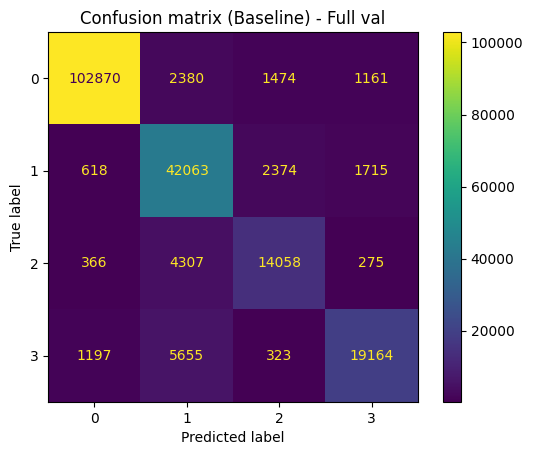

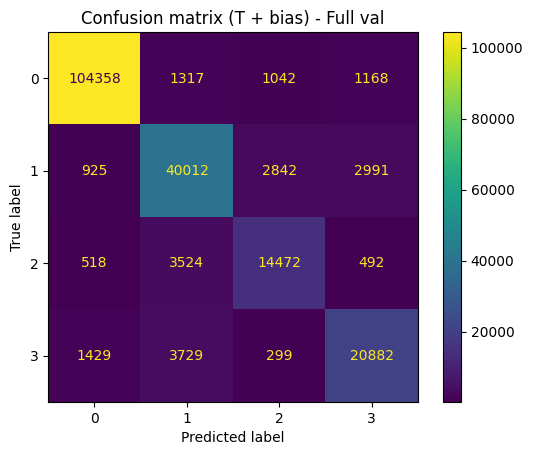

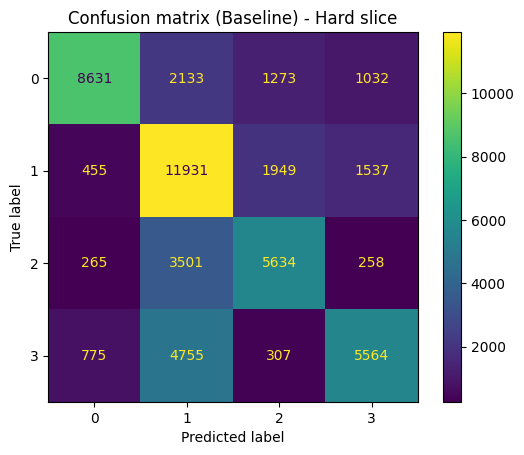

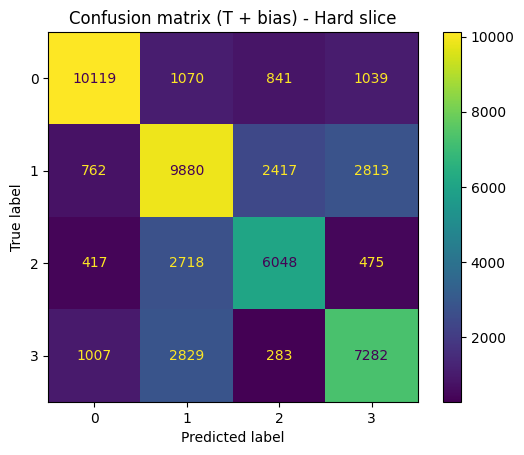

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

BASE_DIR = "/content/drive/MyDrive/runs/codebert_model"

labels = np.load(f"{BASE_DIR}/val_labels.npy").astype(int)
logits = np.load(f"{BASE_DIR}/val_logits.npy")

T = float(np.load(f"{BASE_DIR}/temp_T.npy")[0])
b = np.load(f"{BASE_DIR}/bias_b.npy")

hard = np.load(f"{BASE_DIR}/hard_mask.npy")

C = logits.shape[1]
prior = np.bincount(labels, minlength=C).astype(np.float32)
prior = prior / prior.sum()
log_prior = np.log(prior + 1e-12)

pred_before = np.argmax(logits, axis=1)
pred_after_tb = np.argmax(logits / T + b, axis=1)

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(values_format="d")
    plt.title(title)
    plt.show()

# --- Full val
plot_cm(labels, pred_before,      "Confusion matrix (Baseline) - Full val")
plot_cm(labels, pred_after_tb,    "Confusion matrix (T + bias) - Full val")

# --- Hard slice
plot_cm(labels[hard], pred_before[hard],       "Confusion matrix (Baseline) - Hard slice")
plot_cm(labels[hard], pred_after_tb[hard],     "Confusion matrix (T + bias) - Hard slice")


In [ ]:
import numpy as np
import torch
from itertools import chain
from datasets import load_dataset
from tqdm import tqdm

@torch.no_grad()
def predict_submission_streaming(
    model,
    tokenizer,
    parquet_path,
    output_path,
    max_length=1024,
    batch_size=16,
    device=None,
    # calibration (optional)
    temperature_T: float | None = None,
    bias_b: np.ndarray | None = None,
    log_prior: np.ndarray | None = None,  # shape [C]
):
    """
    Streams inference over parquet with columns ['ID','code'] and writes 'ID,prediction' CSV.

    Calibration options:
      - If temperature_T and bias_b are provided: argmax(logits/T + b)
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    model.to(device)
    model.eval()

    # Stream parquet
    ds = load_dataset("parquet", data_files=parquet_path, split="train", streaming=True)

    # Validate schema and re-chain first row back into stream
    it = iter(ds)
    first = next(it)
    if not {"ID", "code"}.issubset(first.keys()):
        raise ValueError("Parquet file must contain 'ID' and 'code' columns")
    stream = chain([first], it)

    def batcher(iterator, bs):
        buf = []
        for ex in iterator:
            buf.append(ex)
            if len(buf) == bs:
                yield buf
                buf = []
        if buf:
            yield buf

    # prep calibration tensors once
    use_tb = (temperature_T is not None) and (bias_b is not None)

    if use_tb:
        T = float(temperature_T)
        b = torch.tensor(bias_b, dtype=torch.float32, device=device).view(1, -1)

    with open(output_path, "w") as f:
        f.write("ID,prediction\n")

        for batch in tqdm(batcher(stream, batch_size), desc="Predicting"):
            codes = [row["code"] for row in batch]
            ids   = [row["ID"] for row in batch]

            enc = tokenizer(
                codes,
                truncation=True,
                padding=True,
                max_length=max_length,
                return_tensors="pt",
            ).to(device)

            logits = model(**enc).logits  # [B, C]

            if use_tb:
                logits = logits / T + b

            pred_labels = logits.argmax(dim=-1).cpu().tolist()

            for ex_id, pred in zip(ids, pred_labels):
                f.write(f"{ex_id},{pred}\n")

    print(f"Predictions saved to {output_path} | calibrated_Tb={use_tb} | calibrated_tau={use_tau}")


In [ ]:
import os
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_DIR = "/content/drive/MyDrive/runs/results_modernbert_1024"
TEST_PARQUET = "/content/drive/MyDrive/Task_C/test.parquet"  # change

OUT_BASE = "/content/drive/MyDrive/submission_balanced.csv"
OUT_CAL  = "/content/drive/MyDrive/submission_balanced_calibrated.csv"
OUT_CAL_PRIOR = "/content/drive/MyDrive/submission_balanced_calibrated_prior.csv"

tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR, use_fast=True, local_files_only=True)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR, local_files_only=True)

# ---- load calibration params
T = float(np.load(os.path.join(MODEL_DIR, "temp_T.npy"))[0])
b = np.load(os.path.join(MODEL_DIR, "bias_b.npy"))

# ---- compute log_prior (same used in calibration)
labels_val = np.load(os.path.join(MODEL_DIR, "val_labels.npy")).astype(int)
C = b.shape[0]
prior = np.bincount(labels_val, minlength=C).astype(np.float32)
prior = prior / prior.sum()
log_prior = np.log(prior + 1e-12)

# =====================================================
# 1) Baseline submission (no calibration)
# =====================================================
predict_submission_streaming(
    model=model,
    tokenizer=tokenizer,
    parquet_path=TEST_PARQUET,
    output_path=OUT_BASE,
    max_length=1024,
    batch_size=2048,
    temperature_T=None,
    bias_b=None,
)

# =====================================================
# 2) Calibrated submission (T + bias)
# =====================================================
predict_submission_streaming(
    model=model,
    tokenizer=tokenizer,
    parquet_path=TEST_PARQUET,
    output_path=OUT_CAL,
    max_length=1024,
    batch_size=2048,
    temperature_T=T,
    bias_b=b,
)



Predicting: 245it [1:09:52, 17.11s/it]


Predictions saved to /content/drive/MyDrive/submission_balanced.csv | calibrated_Tb=False | calibrated_tau=False


Predicting: 245it [1:09:50, 17.10s/it]


Predictions saved to /content/drive/MyDrive/submission_balanced_calibrated.csv | calibrated_Tb=True | calibrated_tau=False


Predicting: 245it [1:09:50, 17.11s/it]

Predictions saved to /content/drive/MyDrive/submission_balanced_calibrated_prior.csv | calibrated_Tb=True | calibrated_tau=True


In [ ]:
import numpy as np
from tqdm import tqdm

def compute_truncation_stats(
    texts,
    tokenizer,
    max_length=512,
    batch_size=256,
):
    """
    Computes truncation statistics for a list of texts.

    Returns:
      - truncation_rate: % of samples longer than max_length
      - mean_length
      - median_length
      - p90_length
      - p95_length
      - max_length_observed
      - all_lengths (numpy array)
    """

    lengths = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Computing lengths"):
        batch = texts[i : i + batch_size]
        enc = tokenizer(
            batch,
            truncation=False,      # IMPORTANT: no truncation
            padding=False,
            return_attention_mask=False,
            return_token_type_ids=False,
        )
        lengths.extend(len(ids) for ids in enc["input_ids"])

    lengths = np.array(lengths)

    truncation_rate = (lengths > max_length).mean()

    stats = {
        "truncation_rate": truncation_rate,
        "mean_length": float(lengths.mean()),
        "median_length": float(np.median(lengths)),
        "p90_length": float(np.percentile(lengths, 90)),
        "p95_length": float(np.percentile(lengths, 95)),
        "max_length_observed": int(lengths.max()),
        "all_lengths": lengths,
    }

    return stats


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base")
train_df = pd.read_parquet("/content/drive/MyDrive/Task_C/train.parquet")
stats_512 = compute_truncation_stats(
    texts=train_df["code"].tolist(),
    tokenizer=tokenizer,
    max_length=512,
)

stats_1024 = compute_truncation_stats(
    texts=train_df["code"].tolist(),
    tokenizer=tokenizer,
    max_length=1024,
)

print("=== 512 ===")
for k, v in stats_512.items():
    if k != "all_lengths":
        print(f"{k}: {v}")

print("\n=== 1024 ===")
for k, v in stats_1024.items():
    if k != "all_lengths":
        print(f"{k}: {v}")


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

Computing lengths: 100%|██████████| 3516/3516 [03:09<00:00, 18.56it/s]


=== 512 ===
truncation_rate: 0.2659388888888889
mean_length: 409.28033
median_length: 272.0
p90_length: 871.0
p95_length: 1169.0
max_length_observed: 14427

=== 1024 ===
truncation_rate: 0.06397333333333333
mean_length: 409.28033
median_length: 272.0
p90_length: 871.0
p95_length: 1169.0
max_length_observed: 14427
